# Multilateration :

### Scenario Description of our Real Data :
The multilateration technique employed by the OpenSky Network
is based on hyperbolic localization, the same method that has
been proposed for the secure verification of ADS-B position messages.
In hyperbolic localization, the multilateration is performed
through a ranging and a lateration step. 
The range R is the wave speed v (close to the speed of light in air) times the wave propagation
time T . 

The multilateration system estimates the ranges based
on the time-difference-of-arrival Δij of a signal at sensors i and j:

**Δij = Ti-Tj =Ri-Rj/v**

The second step is lateration. From the above equations for the
ranges and the known positions of the sensors (xi; yi; zi), the position
(x; y; z) of the node to be localized can be estimated by calculating
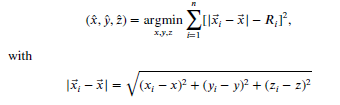
where n corresponds to the number of sensors. To solve these equations,
at least four sensors are needed. The resulting set of equations
is not linear and can not be solved analytically. Several methods exist
to numerically solve the above problem which mainly depend
on the complexity and accuracy. For solving the equations, the
OpenSky Network relies on a computationally lightweight linear
approach . This approach yields one of the most accurate linear
least square solutions for multilateration
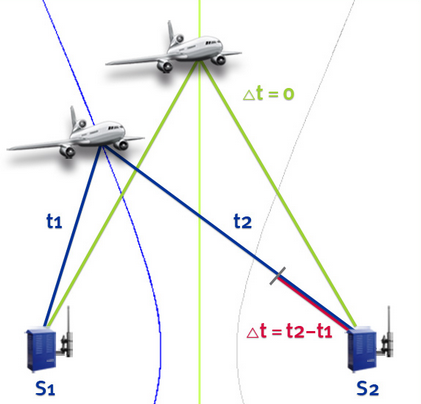
### Algorithm lateration explanation:exTaylor-Series Method
So,the difference between timestamps of different sensors tells us something about the location of the aircraft?
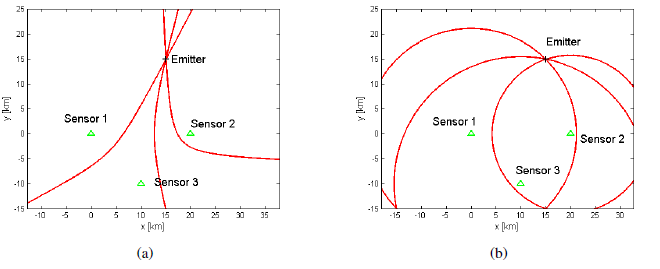
==>(a) TDOA and (b) TOA scenario with hyperbolae and circles respectively as possible
emitter locations.

An unknown emitter Aircraft e = (xT ; x_ T )T sends a signal which several stationary sensors
s(i) = x(i), i = 1; : : :M, receive. The TOA consists on the emitting time t0 and the
time the signal needs to propagate the distance between emitter and sensor i:
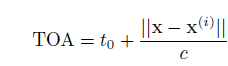
where c is the speed of light.
In reality, TOA measurements are noisy. The measurement noise is modeled as white
Gaussian with standard deviation TOA:
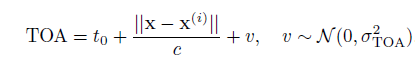

Differentiating two TOAs eliminates the unknown time of emission and delivers a TDOA
measurement. A single twodimensional TDOA measurement defines a hyperbola of possible
target locations while a single TOA measurement describes a circle of possible target
locations when the time of emission can be eliminated,

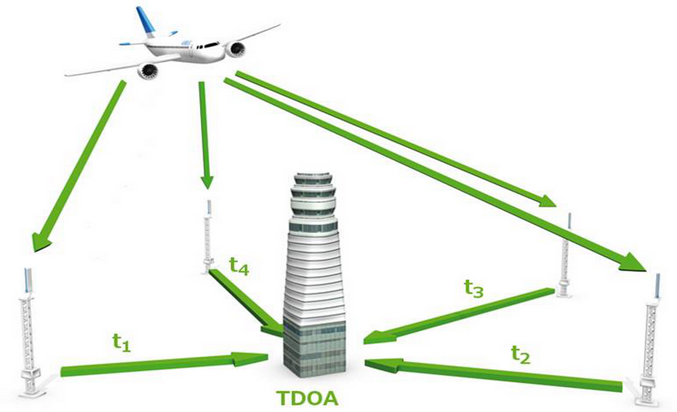
The TDOA samples generated in the Correlator component can be converted into range-difference of arrival (RDOA) samples 
and used to solve for the location of the unknown emitter. 
An RDOA value is simply a TDOA value converted from time in samples to distance in meters.  The RDOA is computed, 
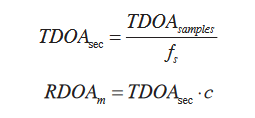
where c is the speed of light in meters per second and fs is the sampling rate of the collector.                                                                                                                                        The emitter aircraft  is located in three-dimensional space.  Because each TDOA measurement requires the difference of arrival at two collectors, four collectors and three TDOA measurements are required to compute the three-dimensional location of the emitter.  Converting the location of the emitter and the collectors from Geodetic (Latitude, Longitude, Altitude) to Cartesian (x, y, z) coordinates, the following RDOA equations are formulated using the Pythagorean theorem, 
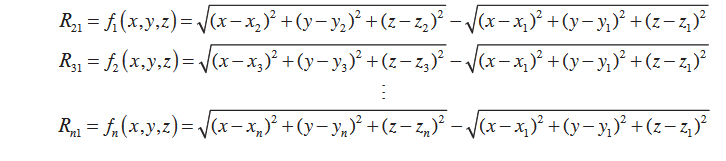
 where x, y, and z are the location of the emitter in Cartesian coordinates, xi, yi, and zi are the location of the ith collector, and Rij is the RDOA measurement between the ith and jth collector. 
Each equation defines a hyperbolic curve with the collectors as points of focus
These equations are non-linear and can be difficult to solve with a closed form solution, even if each measurement is made without error.  The system of equations can be made approximately linear by using the Taylor series expansion centered on an initial estimate for the location of the emitter, neglecting all terms other than the first order , 

 
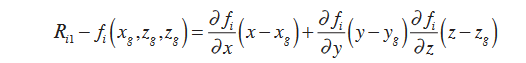
where xg, yg, and zg are the location of the initial guess.
In matrix form this becomes,

                                                                    
where the Jacobian,J, is the set of partial derivatives forming the first order term of the Taylor series expansion, 
                                                                      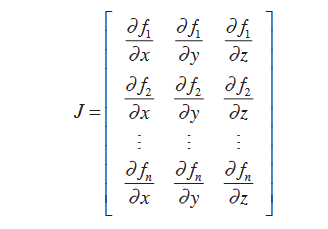
and **ΔM** is the difference between the measured value and the value at the initial guess,

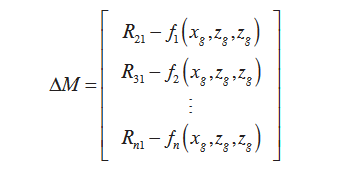

and **ΔX** is the delta between the initial guess and the solution to the Taylor series approximation, 

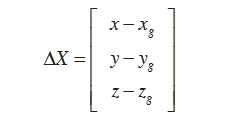
Because this system can be over-determined if there are more equations than unknowns (n > 3) and the measurements are not precise, it cannot be solved exactly, and there will be some error in these equations.
To account for error in the system, equation  can be re-organized as, 
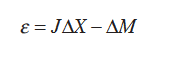
where **ε** is the error. A least-squared minimization can be used to minimize the sum of the squares of the error, 
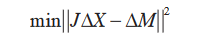

This can be accomplished by multiplying both sides of equation by **JT**, 
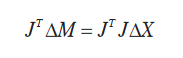
then solving for **ΔX**, 
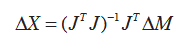
If a confidence can be placed on each measurement, a weighting matrix may be employed to place an appropriate weighting value on each measurement, 
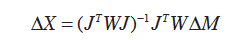
This weighting matrix **W**, is simply a diagonal matrix of weights, 

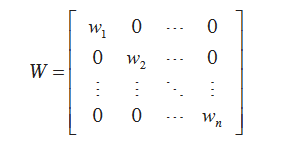
where wi is the weight for each measurement.  If the variance is known for each measurement, the inverse of the diagonal matrix of variances from each measurement can be used as the weighting matrix. In either case,ΔX can then be added to the initial guess, and used as a subsequent guess to approach closer to the solution,
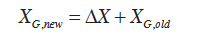

until the absolute value of  **ΔX** is smaller than some minimum error, **errmin**.
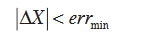
The main problem with this technique is that it can be rather difficult to choose the initial location.  If the initial location is improperly chosen, the iteration can quickly diverge due to the highly imperfect approximation using only the first order part of the Taylor series approximation.  Large steps in each increment can easily jump right over the actual emitter location and possibly never approach the emitter location. Figures   shows a converging iteration sequence where the algorithm gradually approaches the target.  The figure also shows a situation where the algorithm diverges, oscillating around the earth, not finding the emitter. 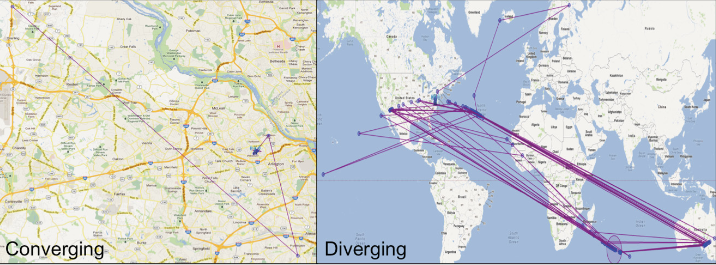


# Multilateration Algorithm using **Sicpy** to resove the problem :

In [1]:
import math
import numpy
from scipy.ndimage import map_coordinates

#functions for multilateration.
#https://math.stackexchange.com/questions/1722021/trilateration-using-tdoa/2489798#2489798 best!!!
#https://github.com/bistromath/gr-air-modes/commit/9b17824c49577afc33e184358d8e5262cfee4927
#https://github.com/jurasofish/multilateration/commit/665da2e04cc71183196bd4d3ebc8fc8b220d13fa
#https://github.com/kn1m/LocalizationTDOA
#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5108751/
#best :https://docplayer.net/48962282-A-python-implementation-of-chan-s-tdoa-algorithm-for-ultrasonic-positioning-and-tracking.html
#this library is more or less based around the so-called "GPS equation", the canonical
#iterative method for getting position from GPS satellite time difference of arrival data.
#here, instead of multiple orbiting satellites with known time reference and position,
#we have multiple fixed stations with known time references (GPSDO, hopefully) and known
#locations (again, GPSDO).

#NB: because of the way this solver works, at least 3 stations and timestamps
#are required. this function will not return hyperbolae for underconstrained systems.
#TODO: get HDOP out of this so we can draw circles of likely position and indicate constraint
########################END NOTES#######################################


#this is a 10x10-degree WGS84 geoid datum, in meters relative to the WGS84 reference ellipsoid. given the maximum slope, you should probably interpolate.
#NIMA suggests a 2x2 interpolation using four neighbors. we'll go cubic spline JUST BECAUSE WE CAN
wgs84_geoid = numpy.array([[13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13],                       #90N
               [3,1,-2,-3,-3,-3,-1,3,1,5,9,11,19,27,31,34,33,34,33,34,28,23,17,13,9,4,4,1,-2,-2,0,2,3,2,1,1],                                       #80N
               [2,2,1,-1,-3,-7,-14,-24,-27,-25,-19,3,24,37,47,60,61,58,51,43,29,20,12,5,-2,-10,-14,-12,-10,-14,-12,-6,-2,3,6,4],                    #70N
               [2,9,17,10,13,1,-14,-30,-39,-46,-42,-21,6,29,49,65,60,57,47,41,21,18,14,7,-3,-22,-29,-32,-32,-26,-15,-2,13,17,19,6],                 #60N
               [-8,8,8,1,-11,-19,-16,-18,-22,-35,-40,-26,-12,24,45,63,62,59,47,48,42,28,12,-10,-19,-33,-43,-42,-43,-29,-2,17,23,22,6,2],            #50N
               [-12,-10,-13,-20,-31,-34,-21,-16,-26,-34,-33,-35,-26,2,33,59,52,51,52,48,35,40,33,-9,-28,-39,-48,-59,-50,-28,3,23,37,18,-1,-11],     #40N
               [-7,-5,-8,-15,-28,-40,-42,-29,-22,-26,-32,-51,-40,-17,17,31,34,44,36,28,29,17,12,-20,-15,-40,-33,-34,-34,-28,7,29,43,20,4,-6],       #30N
               [5,10,7,-7,-23,-39,-47,-34,-9,-10,-20,-45,-48,-32,-9,17,25,31,31,26,15,6,1,-29,-44,-61,-67,-59,-36,-11,21,39,49,39,22,10],           #20N
               [13,12,11,2,-11,-28,-38,-29,-10,3,1,-11,-41,-42,-16,3,17,33,22,23,2,-3,-7,-36,-59,-90,-95,-63,-24,12,53,60,58,46,36,26],             #10N
               [22,16,17,13,1,-12,-23,-20,-14,-3,14,10,-15,-27,-18,3,12,20,18,12,-13,-9,-28,-49,-62,-89,-102,-63,-9,33,58,73,74,63,50,32],          #0
               [36,22,11,6,-1,-8,-10,-8,-11,-9,1,32,4,-18,-13,-9,4,14,12,13,-2,-14,-25,-32,-38,-60,-75,-63,-26,0,35,52,68,76,64,52],                #10S
               [51,27,10,0,-9,-11,-5,-2,-3,-1,9,35,20,-5,-6,-5,0,13,17,23,21,8,-9,-10,-11,-20,-40,-47,-45,-25,5,23,45,58,57,63],                    #20S
               [46,22,5,-2,-8,-13,-10,-7,-4,1,9,32,16,4,-8,4,12,15,22,27,34,29,14,15,15,7,-9,-25,-37,-39,-23,-14,15,33,34,45],                      #30S
               [21,6,1,-7,-12,-12,-12,-10,-7,-1,8,23,15,-2,-6,6,21,24,18,26,31,33,39,41,30,24,13,-2,-20,-32,-33,-27,-14,-2,5,20],                   #40S
               [-15,-18,-18,-16,-17,-15,-10,-10,-8,-2,6,14,13,3,3,10,20,27,25,26,34,39,45,45,38,39,28,13,-1,-15,-22,-22,-18,-15,-14,-10],           #50S
               [-45,-43,-37,-32,-30,-26,-23,-22,-16,-10,-2,10,20,20,21,24,22,17,16,19,25,30,35,35,33,30,27,10,-2,-14,-23,-30,-33,-29,-35,-43],      #60S
               [-61,-60,-61,-55,-49,-44,-38,-31,-25,-16,-6,1,4,5,4,2,6,12,16,16,17,21,20,26,26,22,16,10,-1,-16,-29,-36,-46,-55,-54,-59],            #70S
               [-53,-54,-55,-52,-48,-42,-38,-38,-29,-26,-26,-24,-23,-21,-19,-16,-12,-8,-4,-1,1,4,4,6,5,4,2,-6,-15,-24,-33,-40,-48,-50,-53,-52],     #80S
               [-30,-30,-30,-30,-30,-30,-30,-30,-30,-30,-30,-30,-30,-30,-30,-30,-30,-30,-30,-30,-30,-30,-30,-30,-30,-30,-30,-30,-30,-30,-30,-30,-30,-30,-30,-30]], #90S
               dtype=numpy.float)
               
#ok this calculates the geoid offset from the reference ellipsoid
#combined with LLH->ECEF this gets you XYZ for a ground-referenced point
def wgs84_height(lat, lon):
    yi = numpy.array([9-lat/10.0])
    xi = numpy.array([18+lon/10.0])
    return float(map_coordinates(wgs84_geoid, [yi, xi]))

#WGS84 reference ellipsoid constants
wgs84_a = 6378137.0
wgs84_b = 6356752.314245
wgs84_e2 = 0.0066943799901975848
wgs84_a2 = wgs84_a**2 #to speed things up a bit
wgs84_b2 = wgs84_b**2

#convert ECEF to lat/lon/alt without geoid correction
#returns alt in meters
def ecef2llh(ecef):
    x, y, z = ecef
    ep  = math.sqrt((wgs84_a2 - wgs84_b2) / wgs84_b2)
    p   = math.sqrt(x**2+y**2)
    th  = math.atan2(wgs84_a*z, wgs84_b*p)
    lon = math.atan2(y, x)
    lat = math.atan2(z+ep**2*wgs84_b*math.sin(th)**3, p-wgs84_e2*wgs84_a*math.cos(th)**3)
    N   = wgs84_a / math.sqrt(1-wgs84_e2*math.sin(lat)**2)
    alt = p / math.cos(lat) - N
    
    lon *= (180. / math.pi)
    lat *= (180. / math.pi)
    
    return [lat, lon, alt]

#convert lat/lon/alt coords to ECEF without geoid correction, WGS84 model
#remember that alt is in meters
def llh2ecef(lla):
    lat, lon, alt = lla
    lat *= (math.pi / 180.0)
    lon *= (math.pi / 180.0)
    
    n = lambda x: wgs84_a / math.sqrt(1 - wgs84_e2*(math.sin(x)**2))
    
    x = (n(lat) + alt)*math.cos(lat)*math.cos(lon)
    y = (n(lat) + alt)*math.cos(lat)*math.sin(lon)
    z = (n(lat)*(1-wgs84_e2)+alt)*math.sin(lat)
    
    return [x,y,z]
    
#do both of the above to get a geoid-corrected x,y,z position
def llh2geoid(lla):
    lat, lon, alt = lla
    (x,y,z) = llh2ecef((lat, lon, alt + wgs84_height(lat, lon)))
    return [x,y,z]


c = 299792458  #modified for refractive index of air, why not

#this function is the iterative solver core of the mlat function below
#we use limit as a goal to stop solving when we get "close enough" (error magnitude in meters for that iteration)
#basically 20 meters is way less than the anticipated error of the system so it doesn't make sense to continue
#it's possible this could fail in situations where the solution converges slowly
#TODO: this fails to converge for some seriously advantageous geometry
def mlat_iter(rel_stations, prange_obs, xguess = [0,0,0], limit = 40, maxrounds =200):
    xerr = [10e9, 10e9, 10e9]
    rounds = 0
    while numpy.linalg.norm(xerr) > limit:
        prange_est = [[numpy.linalg.norm(station - xguess)] for station in rel_stations]
        dphat = prange_obs - prange_est
        H = numpy.array([(numpy.array(-rel_stations[row,:])+xguess) / prange_est[row] for row in range(0,len(rel_stations))])
        #now we have H, the Jacobian, and can solve for residual error
        xerr = numpy.linalg.lstsq(H, dphat,rcond=None)[0].flatten()
        xguess += xerr
        #print xguess, xerr
        rounds += 1
        if rounds > maxrounds:
            raise Exception("Failed to converge!")
            break
    return xguess

#func mlat:
#uses a modified GPS pseudorange solver to locate aircraft by multilateration.
#replies is a list of reports, in ([lat, lon, alt], timestamp) format
#altitude is the barometric altitude of the aircraft as returned by the aircraft
#returns the estimated position of the aircraft in (lat, lon, alt) geoid-corrected WGS84.
#let's make it take a list of tuples so we can sort by them
def mlat(replies, altitude):
    sorted_replies = sorted(replies, key=lambda time: time[1])

    stations = [sorted_reply[0] for sorted_reply in sorted_replies]
    timestamps = [sorted_reply[1] for sorted_reply in sorted_replies]

    me_llh = stations[0]
    me = llh2geoid(stations[0])

    
    #list of stations in XYZ relative to me
    rel_stations = [numpy.array(llh2geoid(station)) - numpy.array(me) for station in stations[1:]]
    rel_stations.append([0,0,0] - numpy.array(me))
    rel_stations = numpy.array(rel_stations) #convert list of arrays to 2d array

    #differentiate the timestamps to get TDOA, multiply by c to get pseudorange
    prange_obs = [[c*(stamp-timestamps[0])] for stamp in timestamps[1:]]

    #so here we calc the estimated pseudorange to the center of the earth, using station[0] as a reference point for the geoid
    #in other words, we say "if the aircraft were directly overhead of station[0], this is the prange to the center of the earth"
    #this is a necessary approximation since we don't know the location of the aircraft yet
    #if the dang earth were actually round this wouldn't be an issue
    prange_obs.append( [numpy.linalg.norm(llh2ecef((me_llh[0], me_llh[1], altitude)))] ) #use ECEF not geoid since alt is MSL not GPS
    prange_obs = numpy.array(prange_obs)

    #xguess = llh2ecef([37.617175,-122.400843, 8000])-numpy.array(me)
    #xguess = [0,0,0]
    #start our guess directly overhead, who cares
    xguess = numpy.array(llh2ecef([me_llh[0], me_llh[1], altitude])) - numpy.array(me)
    
    xyzpos = mlat_iter(rel_stations, prange_obs, xguess)
    llhpos = ecef2llh(xyzpos+me)
    
    #now, we could return llhpos right now and be done with it.
    #but the assumption we made above, namely that the aircraft is directly above the
    #nearest station, results in significant error due to the oblateness of the Earth's geometry.
    #so now we solve AGAIN, but this time with the corrected pseudorange of the aircraft altitude
    #this might not be really useful in practice but the sim shows >50m errors without it
    #and <4cm errors with it, not that we'll get that close in reality but hey let's do it right
    prange_obs[-1] = [numpy.linalg.norm(llh2ecef((llhpos[0], llhpos[1], altitude)))]
    xyzpos_corr = mlat_iter(rel_stations, prange_obs, xyzpos) #start off with a really close guess
    llhpos = ecef2llh(xyzpos_corr+me)

    #and now, what the hell, let's try to get dilution of precision data
    #avec is the unit vector of relative ranges to the aircraft from each of the stations
#    for i in range(len(avec)):
#        avec[i] = numpy.array(avec[i]) / numpy.linalg.norm(numpy.array(avec[i]))
#    numpy.append(avec, [[-1],[-1],[-1],[-1]], 1) #must be # of stations
#    doparray = numpy.linalg.inv(avec.T*avec)
#the diagonal elements of doparray will be the x, y, z DOPs.
    
    return llhpos

if __name__ == '__main__':
    #here's some test data to validate the algorithm
    teststations = [[37.76225, -122.44254, 100], [37.680016,-121.772461, 100], [37.385844,-122.083082, 100], [37.701207,-122.309418, 100]]
    testalt      = 8000
    testplane    = numpy.array(llh2ecef([37.617175,-122.400843, testalt]))
    testme       = llh2geoid(teststations[0])
    teststamps   = [10, 
                    10 + numpy.linalg.norm(testplane-numpy.array(llh2geoid(teststations[1]))) / c,
                    10 + numpy.linalg.norm(testplane-numpy.array(llh2geoid(teststations[2]))) / c,
                    10 + numpy.linalg.norm(testplane-numpy.array(llh2geoid(teststations[3]))) / c,
                ]

    print(teststamps)

    replies = []
    for i in range(0, len(teststations)):
        replies.append((teststations[i], teststamps[i]))
    ans = mlat(replies, testalt)
    error = numpy.linalg.norm(numpy.array(llh2ecef(ans))-numpy.array(testplane))
    range = numpy.linalg.norm(llh2geoid(ans)-numpy.array(testme))
    print(testplane-testme)
    print(ans)
    print("Error: %.2fm" % (error))
    print("Range: %.2fkm (from first station in list)" % (range/1000))

[10, 10.000188415831309, 10.000129762649028, 10.000048923098706]
[ -5538.73130554 -15584.23628856  -7902.9029425 ]
[37.617175088532754, -122.40084286182723, 8000.037040053867]
Error: 0.04m
Range: 18.32km (from first station in list)


In [3]:
import pdfkit
pdfkit.from_file('C:/PFE/RapportLatex/Multilateration-A.chaka.html', 'C:/PFE/RapportLatex/Multilateration-A.chaka.pdf')

Loading pages (1/6)
Counting pages (2/6)                                               
Resolving links (4/6)                                                       
Loading headers and footers (5/6)                                           
Printing pages (6/6)
Done                                                                      


True